# Playwright활용 스크린캡처 (GPU가속기)
- Playwright를 이용하여 headless 상태에서 screenshot
- GPU 가속기 설정으로, 스크린캡처 등 속도 가속화

# 설정
```
pip install -r requirements.txt
playwright install
```

- playwright install이 디펜던시로 설치가 되지 않는 경우,
`playwrite install-deps` 를 사용하여 설치



In [ ]:
!pip install playwright

In [8]:
!playwright install

Playwright Host validation warning: 
╔══════════════════════════════════════════════════════╗
║ Host system is missing dependencies to run browsers. ║
║ Please install them with the following command:      ║
║                                                      ║
║     sudo playwright install-deps                     ║
║                                                      ║
║ Alternatively, use apt:                              ║
║     sudo apt-get install libglib2.0-0\               ║
║         libnspr4\                                    ║
║         libnss3\                                     ║
║         libdbus-1-3\                                 ║
║         libatk1.0-0\                                 ║
║         libatk-bridge2.0-0\                          ║
║         libcups2\                                    ║
║         libxcb1\                                     ║
║         libxkbcommon0\                               ║
║         libatspi2.0-0\                           

In [63]:
!playwright install-deps 

Installing dependencies...
Switching to root user to install dependencies...
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease            
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-freefont-ttf is already the newest version (20120503-10build1).
fonts-liberation is already the newest version (1:1.07.4-11).
libasound2 is already the newest version (1.2.6.1-1ubuntu1).
libatk-bridge2.0-0 is already the newest version (2.38.0-3).
libatk1.0-0 is already the newest version (2.36.0-3build1).
libatspi2.0-0 is already the newest version (2.44.0-3).
libcairo-gobject2 is already the newest version (1.16.0-5ubuntu2).
libcair

In [32]:
from PIL import Image
import asyncio
from playwright.async_api import async_playwright
import json
import nest_asyncio

nest_asyncio.apply()

In [68]:


async def get_page_info(page=None):  
    # GPU 가속 상태 확인
    if page:
        gpu_info = await page.evaluate("""() => {
            const canvas = document.createElement('canvas');
            const gl = canvas.getContext('webgl') || canvas.getContext('experimental-webgl');
            
            if (!gl) {
                return { gpuAccelerated: false, reason: 'WebGL not supported' };
            }
            
            const debugInfo = gl.getExtension('WEBGL_debug_renderer_info');
            const vendor = debugInfo ? gl.getParameter(debugInfo.UNMASKED_VENDOR_WEBGL) : 'Unknown';
            const renderer = debugInfo ? gl.getParameter(debugInfo.UNMASKED_RENDERER_WEBGL) : 'Unknown';
            
            return {
                gpuAccelerated: true,
                vendor: vendor,
                renderer: renderer,
                webglVersion: gl.getParameter(gl.VERSION),
                shadingLanguageVersion: gl.getParameter(gl.SHADING_LANGUAGE_VERSION),
                extensions: gl.getSupportedExtensions()
            };
        }""")
        
        # GPU 정보 저장
        with open('gpu_info.json', 'w') as f:
            json.dump(gpu_info, f, indent=2)
                
        # 추가적인 브라우저 정보
        browser_info = await page.evaluate("""() => {
            return {
                userAgent: navigator.userAgent,
                platform: navigator.platform,
                hardwareConcurrency: navigator.hardwareConcurrency,
                deviceMemory: navigator.deviceMemory || 'Not available'
            };
        }""")
    
        with open('browser_info.json', 'w') as f:
            json.dump(browser_info, f, indent=2)
    
    
        return gpu_info, browser_info
    else:
        raise "No Page Instance"
        return False

    
async def capture_screenshot_with_gpu(url, output_path, enable_gpu=True):
    async with async_playwright() as p:
        # GPU 가속 플래그 설정
        # gpu_flags = [
        #     '--enable-gpu-rasterization',
        #     '--ignore-gpu-blocklist',
        #     '--enable-webgl',
        #     '--use-gl=angle',
        #     '--use-angle=metal',
        # ]

        gpu_flags = [
            '--ignore-gpu-blocklist',  # GPU 블랙리스트 무시
            '--enable-gpu-rasterization',  # GPU 래스터화 활성화
            '--enable-raw-draw',  # 성능 개선
            '--use-angle=gl',  # macOS: 'metal', Linux: 'gl-egl'
            '--enable-features=Vulkan,SharedArrayBuffer',
            '--headless=new'  # 새로운 헤드리스 모드 사용
        ]

        no_gpu_flags = [
            '--disable-gpu',                   # GPU 하드웨어 가속 비활성화
            '--disable-gpu-compositing',       # GPU 컴포지팅 비활성화
            '--disable-gpu-rasterization',     # GPU 래스터화 비활성화
            '--disable-software-rasterizer',   # 소프트웨어 래스터라이저 비활성화
            '--disable-webgl',                 # WebGL 비활성화
        ]        

        try:
            # 브라우저 실행
            browser = await p.chromium.launch(
                headless=True,
                args= gpu_flags if enable_gpu else no_gpu_flags,
                chromium_sandbox=False
            )
            
            context = await browser.new_context(
                is_mobile=False,
                has_touch=False,
                # javascript_enabled=True,
                viewport={"width": 1280, "height": 800}
            )
            
            page = await context.new_page()
            
            # 웹사이트 방문
            await page.goto(url)
            await page.screenshot(path=output_path, full_page=True)
            print("스크린샷을 저장하였습니다 : ", output_path)
            
            # GPU 가속 상태 확인
            gpu_info, browser_info = await get_page_info(page)

            # WebGL 지원 페이지에서 렌더러 정보 추출
            await page.goto("https://webglreport.com/")
            renderer = await page.evaluate('''() => {
                const gl = document.createElement('canvas').getContext('webgl');
                return gl.getParameter(gl.RENDERER);
            }''')
            print(f"WebGL Renderer: {renderer}")  # NVIDIA GPU명이 출력되면 성공

            
            
            await browser.close()
            return gpu_info, browser_info
        except Exception as e:
            print(e)
            return None

In [69]:
fname_gpu = "images/screenshot_gpu.png"
gpu_info, browser_info = await capture_screenshot_with_gpu("https://webglsamples.org/dynamic-cubemap/dynamic-cubemap.html", fname_gpu)

스크린샷을 저장하였습니다 :  images/screenshot_gpu.png
WebGL Renderer: WebKit WebGL


In [54]:
gpu_info

{'gpuAccelerated': True,
 'vendor': 'Google Inc. (Google)',
 'renderer': 'ANGLE (Google, Vulkan 1.3.0 (SwiftShader Device (Subzero) (0x0000C0DE)), SwiftShader driver)',
 'webglVersion': 'WebGL 1.0 (OpenGL ES 2.0 Chromium)',
 'shadingLanguageVersion': 'WebGL GLSL ES 1.0 (OpenGL ES GLSL ES 1.0 Chromium)',
 'extensions': ['ANGLE_instanced_arrays',
  'EXT_blend_minmax',
  'EXT_clip_control',
  'EXT_color_buffer_half_float',
  'EXT_depth_clamp',
  'EXT_float_blend',
  'EXT_frag_depth',
  'EXT_polygon_offset_clamp',
  'EXT_shader_texture_lod',
  'EXT_texture_compression_bptc',
  'EXT_texture_compression_rgtc',
  'EXT_texture_filter_anisotropic',
  'EXT_texture_mirror_clamp_to_edge',
  'EXT_sRGB',
  'OES_element_index_uint',
  'OES_fbo_render_mipmap',
  'OES_standard_derivatives',
  'OES_texture_float',
  'OES_texture_float_linear',
  'OES_texture_half_float',
  'OES_texture_half_float_linear',
  'OES_vertex_array_object',
  'WEBGL_color_buffer_float',
  'WEBGL_compressed_texture_astc',
  'WE

In [55]:
browser_info

{'userAgent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/138.0.7204.23 Safari/537.36',
 'platform': 'Linux x86_64',
 'hardwareConcurrency': 192,
 'deviceMemory': 8}

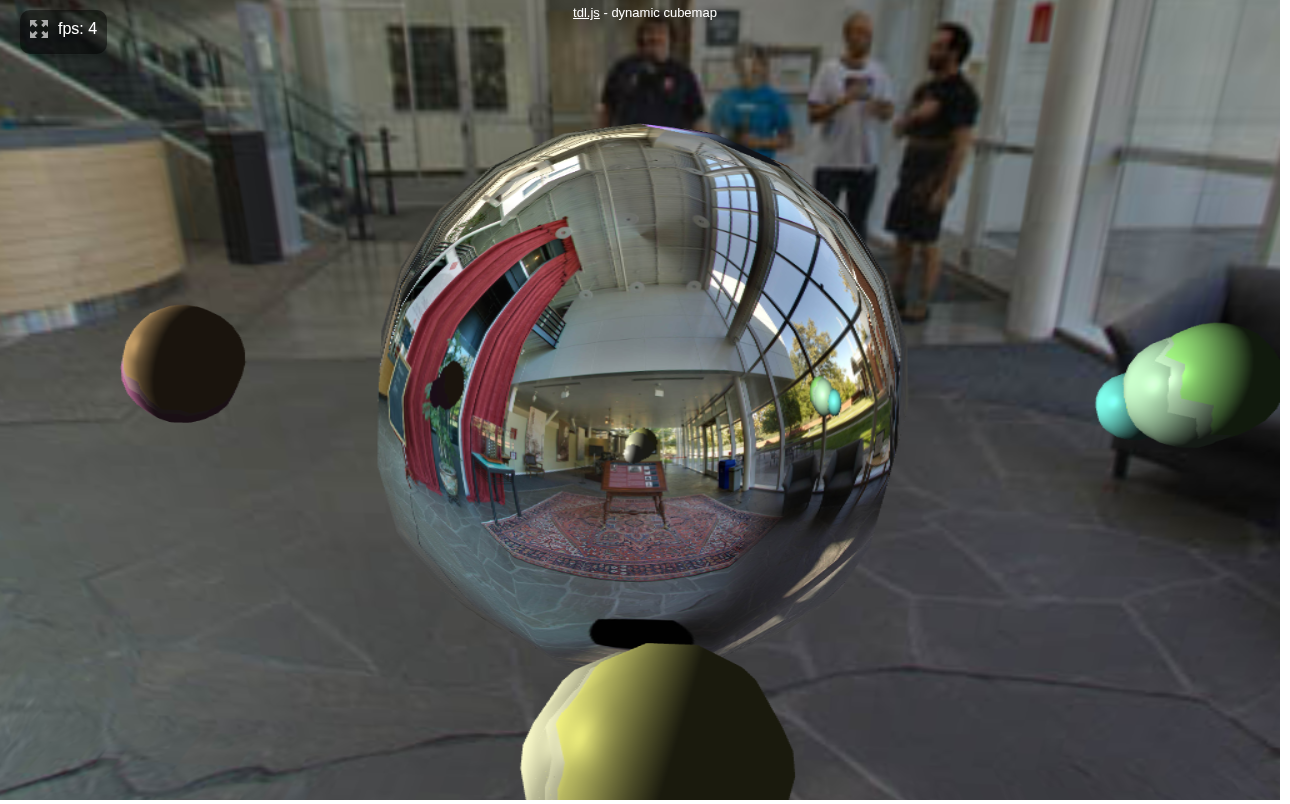

In [56]:
Image.open(fname_gpu)

# GPU를 사용하지 않을때, 비교 

In [59]:
fname_no_gpu = "images/screenshot_no_gpu.png"
gpu_info, browser_info = await capture_screenshot_with_gpu("https://webglsamples.org/dynamic-cubemap/dynamic-cubemap.html", fname, enable_gpu=False)

스크린샷을 저장하였습니다 :  images/screenshot_no_gpu.png


images/screenshot_no_gpu.png


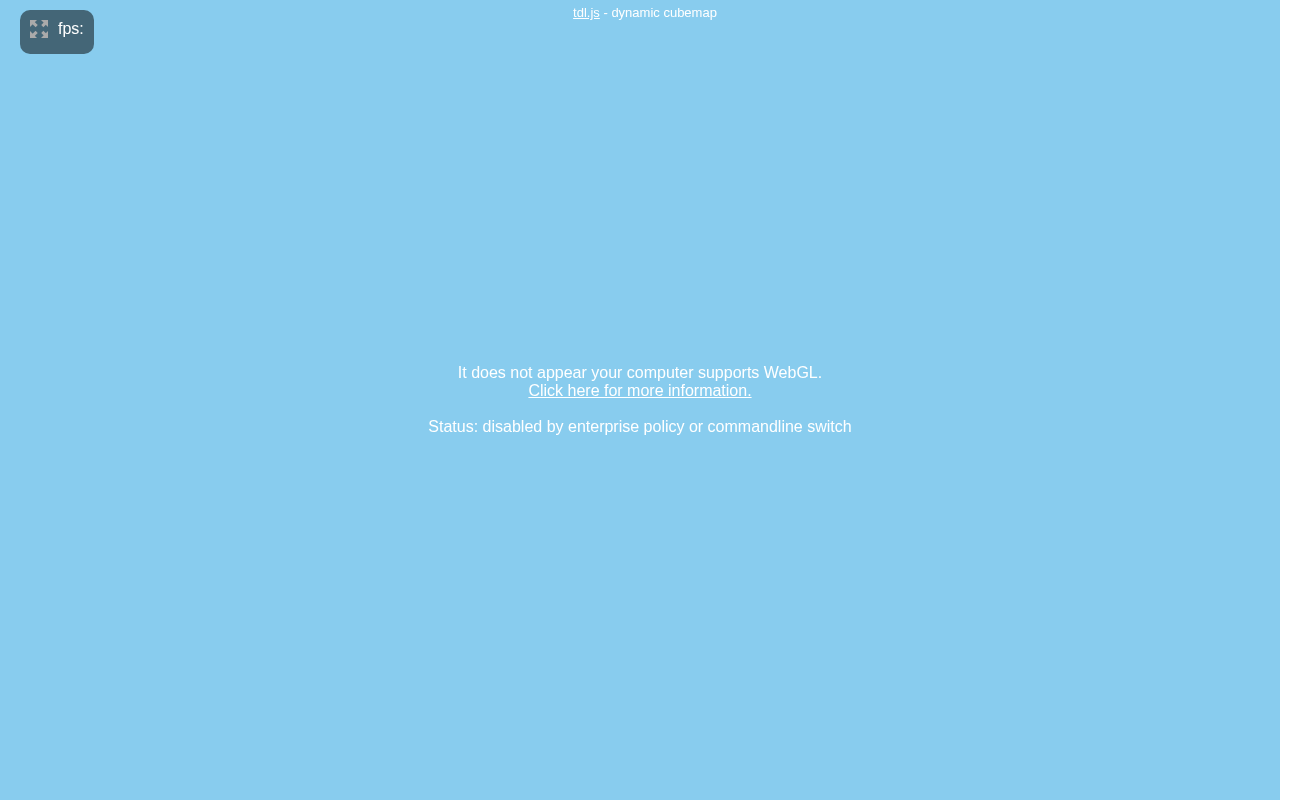

In [60]:
print(fname_no_gpu)
Image.open(fname_no_gpu)

In [64]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # 첫 번째 GPU 선택

# GPU 사용률 측정
utilization = pynvml.nvmlDeviceGetUtilizationRates(handle)
print(f"GPU 사용률: {utilization.gpu}%")
print(f"메모리 사용률: {utilization.memory}%")

pynvml.nvmlShutdown()

GPU 사용률: 0%
메모리 사용률: 0%


In [65]:
# WebGL 지원 페이지에서 렌더러 정보 추출
await page.goto("https://webglreport.com/")
renderer = await page.evaluate('''() => {
    const gl = document.createElement('canvas').getContext('webgl');
    return gl.getParameter(gl.RENDERER);
}''')
print(f"WebGL Renderer: {renderer}")  # NVIDIA GPU명이 출력되면 성공


NameError: name 'page' is not defined